In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from statistics import mean
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pandas.core.common import SettingWithCopyWarning
import warnings
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
user_rating_data_df = pd.read_csv('./datasets/user_score_data.csv', usecols=['user_id', 'mal_id', 'rating'], 
                                  dtype={'user_id':'int32', 'mal_id':'int32', 'rating':'float32'})
user_favorite_data_df = pd.read_csv('./datasets/user_favorited_data.csv', usecols=['user_id', 'mal_id', 'favorited'],
                                   dtype={'user_id':'int32', 'mal_id':'int32', 'rating':'int32'})

In [3]:
user_data_df = user_rating_data_df

In [4]:
print('Shape of ratings dataset is: ', user_rating_data_df.shape, '\n')
print('Max values in dataset are \n', user_rating_data_df.max(), '\n')
print('Min values in dataset are \n', user_rating_data_df.min(), '\n') 

Shape of ratings dataset is:  (948898, 3) 

Max values in dataset are 
 user_id     2195.0
mal_id     42913.0
rating        10.0
dtype: float64 

Min values in dataset are 
 user_id    1.0
mal_id     1.0
rating     0.0
dtype: float64 



In [5]:
user_rating_data_df = user_rating_data_df[user_rating_data_df['rating'] >= 4.0]
print('Shape of ratings dataset is: ', user_rating_data_df.shape, '\n')
print('Max values in dataset are \n', user_rating_data_df.max(), '\n')
print('Min values in dataset are \n', user_rating_data_df.min(), '\n') 

Shape of ratings dataset is:  (783316, 3) 

Max values in dataset are 
 user_id     2195.0
mal_id     42913.0
rating        10.0
dtype: float64 

Min values in dataset are 
 user_id    1.0
mal_id     1.0
rating     4.0
dtype: float64 



In [6]:
users_list = np.unique(user_rating_data_df['user_id'])[:100]
ratings = user_rating_data_df.loc[user_rating_data_df['user_id'].isin(users_list)]
print('Shape of ratings dataset is: ',user_rating_data_df.shape, '\n')
print('Max values in dataset are \n',user_rating_data_df.max(), '\n')
print('Min values in dataset are \n',user_rating_data_df.min(), '\n')
print('Total Users: ', np.unique(user_rating_data_df['user_id']).shape[0])
print('Total Movies which are rated by 100 users: ', np.unique(user_rating_data_df['mal_id']).shape[0]) 

Shape of ratings dataset is:  (783316, 3) 

Max values in dataset are 
 user_id     2195.0
mal_id     42913.0
rating        10.0
dtype: float64 

Min values in dataset are 
 user_id    1.0
mal_id     1.0
rating     4.0
dtype: float64 

Total Users:  2139
Total Movies which are rated by 100 users:  15625


In [7]:
users_fav_movies = ratings.loc[:, ['user_id', 'mal_id']]

In [8]:
users_fav_movies = ratings.reset_index(drop = True)

In [9]:
users_fav_movies.T

0       1        2        3      4      5        6      7      \
user_id      1.0     1.0      1.0      1.0    1.0    1.0      1.0    1.0   
mal_id   29978.0  2467.0  28789.0  34881.0  101.0  713.0  36032.0  656.0   
rating       6.0    10.0      6.0      6.0   10.0    8.0      8.0    5.0   

          8        9      ...   30359    30360    30361    30362    30363  \
user_id     1.0      1.0  ...   100.0    100.0    100.0    100.0    100.0   
mal_id   1485.0  17901.0  ...  4224.0  33352.0  10015.0  15489.0  21595.0   
rating     10.0      6.0  ...    10.0     10.0      9.0      7.0      7.0   

           30364   30365    30366   30367   30368  
user_id    100.0   100.0    100.0   100.0   100.0  
mal_id   16576.0  1195.0  11319.0  1840.0  3712.0  
rating       8.0    10.0      9.0    10.0     9.0  

[3 rows x 30369 columns]

In [10]:
users_fav_movies.to_csv('./datasets/filtered_ratings.csv')

In [11]:
def moviesListForUsers(users, users_data):
    # users = a list of users IDs
    # users_data = a dataframe of users favourite movies or users watched movies
    users_movies_list = []
    for user in users:
        users_movies_list.append(str(list(users_data[users_data['user_id'] == user]['mal_id'])).split('[')[1].split(']')[0])
    return users_movies_list

In [12]:
users = np.unique(users_fav_movies['user_id'])
print(users.shape) 

(100,)


In [87]:
users_movies_list = moviesListForUsers(users, users_fav_movies)

In [14]:
def prepSparseMatrix(list_of_str):
    # list_of_str = A list, which contain strings of users favourite movies separate by comma ",".
    # It will return us sparse matrix and feature names on which sparse matrix is defined 
    # i.e. name of movies in the same order as the column of sparse matrix
    cv = CountVectorizer(token_pattern = r'[^\,\ ]+', lowercase = False)
    sparseMatrix = cv.fit_transform(list_of_str)
    return sparseMatrix.toarray(), cv.get_feature_names()

In [15]:
sparseMatrix, feature_names = prepSparseMatrix(users_movies_list)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [16]:
df_sparseMatrix = pd.DataFrame(sparseMatrix, index = users, columns = feature_names)
df_sparseMatrix

1  100  1000  10012  10015  10017  1002  10020  10029  1003  ...  996  \
1    0    0     0      0      0      0     0      0      0     0  ...    0   
2    1    0     0      0      0      0     0      1      0     1  ...    0   
3    1    0     0      0      0      0     0      1      0     0  ...    0   
4    0    0     0      0      0      0     0      0      0     0  ...    0   
5    0    0     0      0      0      0     0      0      0     0  ...    0   
..  ..  ...   ...    ...    ...    ...   ...    ...    ...   ...  ...  ...   
96   1    0     0      0      0      0     0      0      1     0  ...    0   
97   0    0     0      0      0      0     0      0      0     0  ...    0   
98   0    0     0      0      0      0     0      0      0     0  ...    0   
99   0    0     0      0      0      0     0      0      0     0  ...    0   
100  0    0     0      0      1      0     0      0      0     0  ...    0   

     9963  9969  997  9981  9982  9988  9989  9996  9999  
1       1     0    0     0     0     0     0     0     0  
2       0     0    0     0     1     0     1     0     0  
3       0     0    0     0     0     0     1     0     0  
4       0     0    0     0     0     0     0     0     0  
5       0     0    0     0     0     0     1     0     0  
..    ...   ...  ...   ...   ...   ...   ...   ...   ...  
96      0     1    0     0     0     0     1     0     0  
97      0     0    0     0     0     0     0     0     0  
98      0     0    0     0     0     0     1     0     0  
99      0     0    0     0     0     0     0     0     0  
100     0     0    0     0     0     0     1     0     0  

[100 rows x 4914 columns]

In [17]:
first_6_users_SM = users_fav_movies[users_fav_movies['user_id'].isin(users[:6])].sort_values('user_id')
first_6_users_SM.T

0        299     298     297    296    295      294      293   \
user_id      1.0      1.0     1.0     1.0    1.0    1.0      1.0      1.0   
mal_id   29978.0  10620.0  3550.0  5962.0  333.0  518.0  10519.0  12101.0   
rating       6.0     10.0    10.0    10.0   10.0   10.0      5.0      7.0   

            292     291   ...     2744     2743     2742     2741     2740  \
user_id      1.0     1.0  ...      6.0      6.0      6.0      6.0      6.0   
mal_id   25517.0  8310.0  ...  32086.0  36308.0  12115.0  12113.0  10218.0   
rating      10.0    10.0  ...      5.0     10.0      5.0      5.0      5.0   

            2739     2738    2737    2747     2812  
user_id      6.0      6.0     6.0     6.0      6.0  
mal_id   34055.0  32379.0  9513.0  8939.0  37521.0  
rating       4.0      4.0     9.0     6.0      7.0  

[3 rows x 2813 columns]

In [18]:
df_sparseMatrix.loc[np.unique(first_6_users_SM['user_id']), list(map(str, np.unique(first_6_users_SM['mal_id'])))]

1  5  6  16  19  20  24  27  30  32  ...  40936  41053  41168  41226  \
1  0  0  0   0   1   1   0   0   0   0  ...      0      0      0      0   
2  1  1  1   1   0   1   1   1   0   0  ...      0      0      0      0   
3  1  0  1   0   1   1   1   0   1   1  ...      1      1      1      0   
4  0  0  0   0   0   0   0   0   1   1  ...      0      1      0      0   
5  0  0  0   0   0   1   0   0   0   0  ...      0      0      0      1   
6  1  1  0   0   0   0   0   0   0   0  ...      0      0      0      0   

   41570  41590  41611  42091  42519  42603  
1      1      1      0      1      0      0  
2      0      0      0      0      0      0  
3      0      0      0      0      1      1  
4      0      0      1      0      0      0  
5      0      0      0      0      0      0  
6      0      0      0      0      0      0  

[6 rows x 2007 columns]

In [19]:
from sklearn.cluster import KMeans

In [20]:
class elbowMethod():
    def __init__(self, sparseMatrix):
        self.sparseMatrix = sparseMatrix
        self.wcss = list()
        self.differences = list()
    def run(self, init, upto, max_iterations = 300):
        for i in range(init, upto + 1):
            kmeans = KMeans(n_clusters=i, init = 'k-means++', max_iter = max_iterations, n_init = 10, random_state = 0)
            kmeans.fit(sparseMatrix)
            self.wcss.append(kmeans.inertia_)
        self.differences = list()
        for i in range(len(self.wcss)-1):
            self.differences.append(self.wcss[i] - self.wcss[i+1])
    def showPlot(self, boundary = 500, upto_cluster = None):
        if upto_cluster is None:
            WCSS = self.wcss
            DIFF = self.differences
        else:
            WCSS = self.wcss[:upto_cluster]
            DIFF = self.differences[:upto_cluster - 1]
        plt.figure(figsize=(15, 6))
        plt.subplot(121).set_title('Elbow Method Graph')
        plt.plot(range(1, len(WCSS) + 1), WCSS)
        plt.grid(b = True)
        plt.subplot(122).set_title('Differences in Each Two Consective Clusters')
        len_differences = len(DIFF)
        X_differences = range(1, len_differences + 1)
        plt.plot(X_differences, DIFF)
        plt.plot(X_differences, np.ones(len_differences)*boundary, 'r')
        plt.plot(X_differences, np.ones(len_differences)*(-boundary), 'r')
        plt.grid()
        plt.show()

In [21]:
elbow_method = elbowMethod(sparseMatrix) 

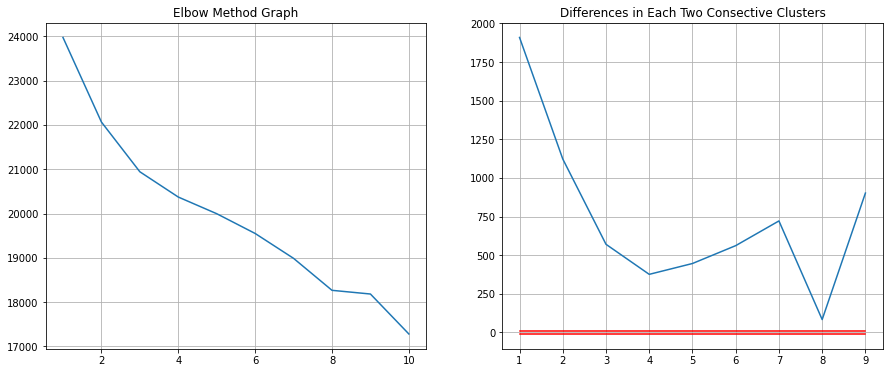

In [22]:
elbow_method.run(1, 10)
elbow_method.showPlot(boundary = 10)

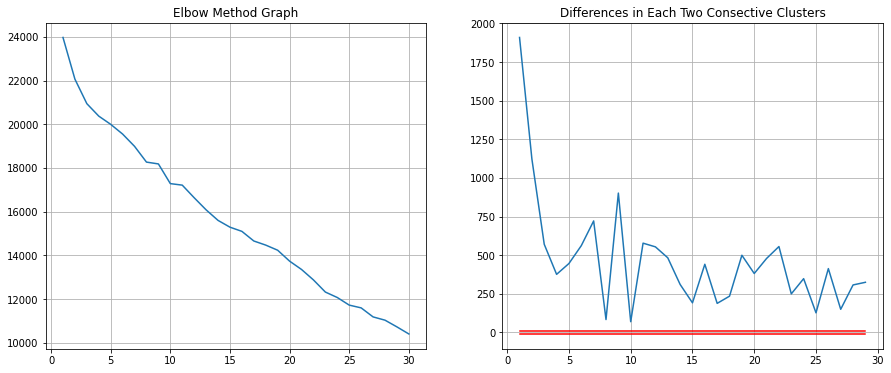

In [23]:
elbow_method.run(11, 30)
elbow_method.showPlot(boundary = 10)

In [24]:
kmeans = KMeans(n_clusters=15, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
clusters = kmeans.fit_predict(sparseMatrix)

In [25]:
users_cluster = pd.DataFrame(np.concatenate((users.reshape(-1,1), clusters.reshape(-1,1)), axis = 1), columns = ['user_id', 'Cluster'])
users_cluster.T

0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  \
user_id   1   2   3   4   5   6   7   8   9  10  ...  91  92  93  94  95  96   
Cluster   9  13   2   5   9   5   5   9   9   1  ...   1   9   9   9   5   0   

         96  97  98   99  
user_id  97  98  99  100  
Cluster   9   9   5    9  

[2 rows x 100 columns]

In [26]:
def clustersMovies(users_cluster, users_data):
    clusters = list(users_cluster['Cluster'])
    each_cluster_movies = list()
    for i in range(len(np.unique(clusters))):
        users_list = list(users_cluster[users_cluster['Cluster'] == i]['user_id'])
        users_movies_list = list()
        for user in users_list:    
            users_movies_list.extend(list(users_data[users_data['user_id'] == user]['mal_id']))
        users_movies_counts = list()
        users_movies_counts.extend([[movie, users_movies_list.count(movie)] for movie in np.unique(users_movies_list)])
        each_cluster_movies.append(pd.DataFrame(users_movies_counts, columns=['mal_id', 'Count']).sort_values(by = ['Count'], ascending = False).reset_index(drop=True))
    return each_cluster_movies
cluster_movies = clustersMovies(users_cluster, users_fav_movies)

In [27]:
cluster_movies[1].T

0      1      2      3      4      5      6      7      8     9     \
mal_id  3784  37976  30015  38000  37999  17265  16782  30276  32827  2025   
Count      3      3      3      3      3      3      3      3      3     3   

        ...  1320   1321   1322   1323   1324   1325   1326   1327   1328  \
mal_id  ...  9989  10020  10050  10163  10218  10271  10278  10396  10397   
Count   ...     1      1      1      1      1      1      1      1      1   

         1329  
mal_id  41168  
Count       1  

[2 rows x 1330 columns]

In [28]:
for i in range(15):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users)

Users in Cluster 0 ->  6
Users in Cluster 1 ->  3
Users in Cluster 2 ->  1
Users in Cluster 3 ->  4
Users in Cluster 4 ->  1
Users in Cluster 5 ->  35
Users in Cluster 6 ->  1
Users in Cluster 7 ->  1
Users in Cluster 8 ->  1
Users in Cluster 9 ->  42
Users in Cluster 10 ->  1
Users in Cluster 11 ->  1
Users in Cluster 12 ->  1
Users in Cluster 13 ->  1
Users in Cluster 14 ->  1


## Get user favourite movie list

In [29]:
def getMoviesOfUser(user_id, users_data):
    return list(users_data[users_data['user_id'] == user_id]['mal_id'])

In [30]:
def fixClusters(clusters_movies_dataframes, users_cluster_dataframe, users_data, smallest_cluster_size = 11):
    # clusters_movies_dataframes: will be a list which will contain each dataframes of each cluster movies
    # users_cluster_dataframe: will be a dataframe which contain users IDs and their cluster no.
    # smallest_cluster_size: is a smallest cluster size which we want for a cluster to not remove
    each_cluster_movies = clusters_movies_dataframes.copy()
    users_cluster = users_cluster_dataframe.copy()
    # Let convert dataframe in each_cluster_movies to list with containing only movies IDs
    each_cluster_movies_list = [list(df['mal_id']) for df in each_cluster_movies]
    # First we will prepair a list which containt lists of users in each cluster -> [[Cluster 0 Users], [Cluster 1 Users], ... ,[Cluster N Users]] 
    usersInClusters = list()
    total_clusters = len(each_cluster_movies)
    for i in range(total_clusters):
        usersInClusters.append(list(users_cluster[users_cluster['Cluster'] == i]['user_id']))
    uncategorizedUsers = list()
    i = 0
    # Now we will remove small clusters and put their users into another list named "uncategorizedUsers"
    # Also when we will remove a cluster, then we have also bring back cluster numbers of users which comes after deleting cluster
    # E.g. if we have deleted cluster 4 then their will be users whose clusters will be 5,6,7,..,N. So, we'll bring back those users cluster number to 4,5,6,...,N-1.
    for j in range(total_clusters):
        if len(usersInClusters[i]) < smallest_cluster_size:
            uncategorizedUsers.extend(usersInClusters[i])
            usersInClusters.pop(i)
            each_cluster_movies.pop(i)
            each_cluster_movies_list.pop(i)
            users_cluster.loc[users_cluster['Cluster'] > i, 'Cluster'] -= 1
            i -= 1
        i += 1
    for user in uncategorizedUsers:
        elemProbability = list()
        user_movies = getMoviesOfUser(user, users_data)
        if len(user_movies) == 0:
            print(user)
        user_missed_movies = list()
        for movies_list in each_cluster_movies_list:
            count = 0
            missed_movies = list()
            for movie in user_movies:
                if movie in movies_list:
                    count += 1
                else:
                    missed_movies.append(movie)
            elemProbability.append(count / len(user_movies))
            user_missed_movies.append(missed_movies)
        user_new_cluster = np.array(elemProbability).argmax()
        users_cluster.loc[users_cluster['user_id'] == user, 'Cluster'] = user_new_cluster
        if len(user_missed_movies[user_new_cluster]) > 0:
            each_cluster_movies[user_new_cluster] = each_cluster_movies[user_new_cluster].append([{'mal_id': new_movie, 'Count': 1} for new_movie in user_missed_movies[user_new_cluster]], ignore_index = True)
    return each_cluster_movies, users_cluster

In [31]:
movies_df_fixed, clusters_fixed = fixClusters(cluster_movies, users_cluster, users_fav_movies, smallest_cluster_size = 6)

In [32]:
j = 0
for i in range(15):
    len_users = users_cluster[users_cluster['Cluster'] == i].shape[0]
    if len_users < 6:
        print('Users in Cluster ' + str(i) + ' -> ', len_users)
        j += 1
print('Total Cluster which we want to remove -> ', j) 

Users in Cluster 1 ->  3
Users in Cluster 2 ->  1
Users in Cluster 3 ->  4
Users in Cluster 4 ->  1
Users in Cluster 6 ->  1
Users in Cluster 7 ->  1
Users in Cluster 8 ->  1
Users in Cluster 10 ->  1
Users in Cluster 11 ->  1
Users in Cluster 12 ->  1
Users in Cluster 13 ->  1
Users in Cluster 14 ->  1
Total Cluster which we want to remove ->  12


In [33]:
print('Length of total clusters before fixing is -> ', len(cluster_movies))
print('Max value in users_cluster dataframe column Cluster is -> ', users_cluster['Cluster'].max())
print('And dataframe is following')
users_cluster.T 

Length of total clusters before fixing is ->  15
Max value in users_cluster dataframe column Cluster is ->  14
And dataframe is following


0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  \
user_id   1   2   3   4   5   6   7   8   9  10  ...  91  92  93  94  95  96   
Cluster   9  13   2   5   9   5   5   9   9   1  ...   1   9   9   9   5   0   

         96  97  98   99  
user_id  97  98  99  100  
Cluster   9   9   5    9  

[2 rows x 100 columns]

In [34]:
print('Length of total clusters after fixing is -> ', len(movies_df_fixed))
print('Max value in users_cluster dataframe column Cluster is -> ', clusters_fixed['Cluster'].max())
print('And fixed dataframe is following')
clusters_fixed.T 

Length of total clusters after fixing is ->  3
Max value in users_cluster dataframe column Cluster is ->  2
And fixed dataframe is following


0   1   2   3   4   5   6   7   8   9   ...  90  91  92  93  94  95  \
user_id   1   2   3   4   5   6   7   8   9  10  ...  91  92  93  94  95  96   
Cluster   2   2   2   1   2   1   1   2   2   2  ...   2   2   2   2   1   0   

         96  97  98   99  
user_id  97  98  99  100  
Cluster   2   2   1    2  

[2 rows x 100 columns]

In [35]:
print('Size of movies dataframe after fixing -> ', len(movies_df_fixed))

Size of movies dataframe after fixing ->  3


In [36]:
for i in range(len(movies_df_fixed)):
    len_users = clusters_fixed[clusters_fixed['Cluster'] == i].shape[0]
    print('Users in Cluster ' + str(i) + ' -> ', len_users) 

Users in Cluster 0 ->  6
Users in Cluster 1 ->  35
Users in Cluster 2 ->  59


In [37]:
for i in range(len(movies_df_fixed)):
    print('Total movies in Cluster ' + str(i) + ' -> ', movies_df_fixed[i].shape[0]) 

Total movies in Cluster 0 ->  1216
Total movies in Cluster 1 ->  2667
Total movies in Cluster 2 ->  4976


In [38]:
class saveLoadFiles:
    def save(self, filename, data):
        try:
            file = open('datasets/' + filename + '.pkl', 'wb')
            pickle.dump(data, file)
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            file.close()
            return [True]
    def load(self, filename):
        try:
            file = open('datasets/' + filename + '.pkl', 'rb')
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            file.close()
            return [False, err]
        else:
            data = pickle.load(file)
            file.close()
            return data
    def loadClusterMoviesDataset(self):
        return self.load('clusters_movies_dataset')
    def saveClusterMoviesDataset(self, data):
        return self.save('clusters_movies_dataset', data)
    def loadUsersClusters(self):
        return self.load('users_clusters')
    def saveUsersClusters(self, data):
        return self.save('users_clusters', data)

In [39]:
import pickle
import sys
from sys import exc_info

In [40]:
saveLoadFile = saveLoadFiles()
print(saveLoadFile.saveClusterMoviesDataset(movies_df_fixed))
print(saveLoadFile.saveUsersClusters(clusters_fixed))

[True]
[True]


In [41]:
load_movies_list, load_users_clusters = saveLoadFile.loadClusterMoviesDataset(), saveLoadFile.loadUsersClusters()
print('Type of Loading list of Movies dataframes of 5 Clusters: ', type(load_movies_list), ' and Length is: ', len(load_movies_list))
print('Type of Loading 100 Users clusters Data: ', type(load_users_clusters), ' and Shape is: ', load_users_clusters.shape) 

Type of Loading list of Movies dataframes of 5 Clusters:  <class 'list'>  and Length is:  3
Type of Loading 100 Users clusters Data:  <class 'pandas.core.frame.DataFrame'>  and Shape is:  (100, 2)


In [42]:
class userRequestedFor:
    def __init__(self, user_id, users_data):
        self.users_data = users_data.copy()
        self.user_id = user_id
        # Find User Cluster
        users_cluster = saveLoadFiles().loadUsersClusters()
        self.user_cluster = int(users_cluster[users_cluster['user_id'] == self.user_id]['Cluster'])
        # Load User Cluster Movies Dataframe
        self.movies_list = saveLoadFiles().loadClusterMoviesDataset()
        self.cluster_movies = self.movies_list[self.user_cluster] # dataframe
        self.cluster_movies_list = list(self.cluster_movies['mal_id']) # list
    def updatedFavouriteMoviesList(self, new_movie_Id):
        if new_movie_Id in self.cluster_movies_list:
            self.cluster_movies.loc[self.cluster_movies['mal_id'] == new_movie_Id, 'Count'] += 1
        else:
            self.cluster_movies = self.cluster_movies.append([{'mal_id':new_movie_Id, 'Count': 1}], ignore_index=True)
        self.cluster_movies.sort_values(by = ['Count'], ascending = False, inplace= True)
        self.movies_list[self.user_cluster] = self.cluster_movies
        saveLoadFiles().saveClusterMoviesDataset(self.movies_list)

    def recommendMostFavouriteMovies(self):
        try:
            user_movies = getMoviesOfUser(self.user_id, self.users_data)
            cluster_movies_list = self.cluster_movies_list.copy()
            for user_movie in user_movies:
                if user_movie in cluster_movies_list:
                    cluster_movies_list.remove(user_movie)
            return [True, cluster_movies_list]
        except KeyError:
            err = "User history does not exist"
            print(err)
            return [False, err]
        except:
            err = 'Error: {0}, {1}'.format(exc_info()[0], exc_info()[1])
            print(err)
            return [False, err]

In [43]:
animes_df = pd.read_csv('./datasets/anime_data.csv', usecols=['mal_id', 'title', 'genres'])
animes_df.head(3)

mal_id                                             genres  \
0       1  ['Action', 'Adventure', 'Comedy', 'Drama', 'Sc...   
1     100  ['Comedy', 'Drama', 'Fantasy', 'Magic', 'Roman...   
2    1000  ['Action', 'Sci-Fi', 'Adventure', 'Space', 'Dr...   

                                  title  
0                          Cowboy Bebop  
1  Shin Shirayuki-hime Densetsu Prétear  
2         Uchuu Kaizoku Captain Herlock

In [44]:
# animes_df = animes_df.loc[
#     animes_df['mal_id'].isin(list(map(str, np.unique(users_fav_movies['mal_id']))))].reset_index(drop=True)

In [45]:
# df = pd.merge(users_fav_movies, animes_df[['mal_id', 'title', 'genres']], on='mal_id')
df = users_fav_movies.merge(animes_df, on = 'mal_id')
df

user_id  mal_id  rating  \
0            1   29978     6.0   
1           36   29978     5.0   
2           70   29978     5.0   
3            1    2467    10.0   
4            1   28789     6.0   
...        ...     ...     ...   
30311       96   32868     4.0   
30312       96   19945     5.0   
30313       98   22835     7.0   
30314      100   21595     7.0   
30315      100   16576     8.0   

                                               genres  \
0                                          ['Comedy']   
1                                          ['Comedy']   
2                                          ['Comedy']   
3                                       ['Adventure']   
4                        ['Music', 'Drama', 'Seinen']   
...                                               ...   
30311                                       ['Music']   
30312                                      ['Comedy']   
30313  ['Slice of Life', 'Comedy', 'Ecchi', 'School']   
30314        ['Action', 'Fantasy', 'Game', 'Shounen']   
30315        ['Action', 'Fantasy', 'Game', 'Shounen']   

                                                   title  
0                                                    001  
1                                                    001  
2                                                    001  
3          3 Choume no Tama: Uchi no Tama Shirimasen ka?  
4                  3-gatsu no Lion meets Bump of Chicken  
...                                                  ...  
30311                                    Spring Stranger  
30312  Zoku Natsume Yuujinchou: 3D Nyanko-sensei Gekijou  
30313                                           Himegoto  
30314  Yu☆Gi☆Oh! Zexal Second: Iza! Saishuu Kessen e!...  
30315  Yu☆Gi☆Oh! Zexal Second: Midokoro Tenkomori Spe...  

[30316 rows x 5 columns]

In [46]:
# df.tail(10)

In [47]:
# df = df.drop_duplicates(['user_id','title'])

In [48]:
# df.tail(10)

In [ ]:
user12Movies = getMoviesOfUser(2, users_fav_movies)
for movie in user12Movies:
    title = list(df.loc[df['user_id'] == 1]['title'])
    if title != []:
        print('Movie title: ', title, ', Genres: [ ', end = '')
        genres = ast.literal_eval(df.loc[df['user_id'] == 1]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre[0], end = '')
        print(']', end = '')
        print('')

Movie title:  ['001', '3 Choume no Tama: Uchi no Tama Shirimasen ka?', '3-gatsu no Lion meets Bump of Chicken', 'Aho Girl', 'Air', 'Air Movie', 'Air Recap', 'Air in Summer', 'Akachan to Boku', 'All Alone With You', 'Angel Densetsu', 'Anger', 'Anime Himitsu no Hanazono', 'Answer (2016)', 'Anyamal Tantei Kiruminzoo', 'Aoki Densetsu Shoot!', 'Arabian Nights: Sindbad no Bouken (TV)', 'Araiguma Rascal', 'Arte', 'B Who I Want 2 B', 'B-Legend! Battle B-Daman', 'Bakemono no Ko', 'Baki', 'Baki 2nd Season', 'Bakugan Battle Brawlers', 'Bakukyuu Hit! Crash B-Daman', 'Bakukyuu Renpatsu!! Super B-Daman', "Bakusou Kyoudai Let's & Go MAX", 'Bakuten Shoot Beyblade', 'Baoh Raihousha', 'Basilisk: Kouga Ninpou Chou', 'Beautiful World', 'Big Order', 'Big Order (TV)', 'Black Cat (TV)', 'Black★Rock Shooter', 'Blue Star feat. Hatsune Miku', 'Boku dake ga Inai Machi', 'Boku dake ga Inai Machi Recaps', 'Boku no Hero Academia', 'Boku no Hero Academia: Sukue! Kyuujo Kunren!', 'Bokura no Live Kimi to no Life', 'Bo

In [85]:
user12Recommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
for movie in user12Recommendations[:15]:
    title = list(df.loc[df['user_id'] == 1]['mal_id'])
    if title != []:
        genres = ast.literal_eval(df.loc[df['user_id'] == 1]['genres'].values[0].split('[')[1].split(']')[0])
        for genre in genres:
            print(genre[0], end = '')
        print(']', end = '')
        print() 

Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]
Comedy]


In [ ]:
users_fav_movies.head()

In [ ]:
user12Recommendations = userRequestedFor(12, users_fav_movies).recommendMostFavouriteMovies()[1]
title = list(df.loc[df['user_id'] == 1]['title'])
print(title)

In [ ]:
user12Recommendations

In [62]:
anime_rec = df['title'].values

anime_rec_list = []
for rec in anime_rec:
    if rec not in anime_rec_list:
        anime_rec_list.append(rec)

In [64]:
anime_rec_list[:10]

['001',
 '3 Choume no Tama: Uchi no Tama Shirimasen ka?',
 '3-gatsu no Lion meets Bump of Chicken',
 'Aho Girl',
 'Air',
 'Air Movie',
 'Air Recap',
 'Air in Summer',
 'Akachan to Boku',
 'All Alone With You']

In [60]:
df['title'].values

array(['001', '001', '001', ..., 'Himegoto',
       'Yu☆Gi☆Oh! Zexal Second: Iza! Saishuu Kessen e!! Special',
       'Yu☆Gi☆Oh! Zexal Second: Midokoro Tenkomori Special'], dtype=object)